In [1]:
import numpy as np
import math
import matplotlib.animation
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
from matplotlib.patches import Circle
from scipy.integrate import solve_ivp

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
m = 0.58  # masa piłki [kg]
l = 7.24  # linia rzutów za trzy punkty (od środka obręczy) [m]
h0 = 3.05  # wysokość na jakiej umieszczone są kosze [m]
hk = 2.7  # wysokość z jakiej rzucana jest piłka [m]
cx = cy = 0.45  # współczynniki oporu
D0 = 0.45  # średnica obręczy kosza [m]
D1 = 0.24  # średnica piłki [m]
rho_p = 1.2  # gęstość powietrza [kg/m^3]
g = 9.81  # przyspieszenie ziemskie [m/s^2]

basket_radius = D0 / 2  # promień obręczy kosza [m]
ball_radius = D1 / 2  # promień piłki [m]
area = np.pi * basket_radius ** 2  # pole powierzchni kosza [m^2]

In [3]:
def euclidean_distance(x1, y1, x2, y2):
    """Metryka euklidesowa."""
    
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [4]:
def calculate_motion_derivatives(t, y, air_resistance_model):
    """
    Oblicza pochodne równań ruchu z uwzględnieniem oporu powietrza do późniejszej symulacji ruchu.

    Parametery:
    t: float
        Czas [s].
    y: list
        Lista stanów początkowych [x0, vx0, y0, vy0].
    air_resistance_model: str
        'liniowy' lub 'kwadratowy' model oporu powietrza.

    Wyjście:
    dydt: list
        Pochodne [vx, ax, vy, ay].
    """
    
    x, vx, y, vy = y
    # v = np.sqrt(vx**2 + vy**2)  # aktualna prędkość

    if air_resistance_model == 'liniowy':
        force_x = 0.5 * cx * rho_p * area * vx
        force_y = 0.5 * cy * rho_p * area * vy
    elif air_resistance_model == 'kwadratowy':
        force_x = 0.5 * cx * rho_p * area * pow(vx, 2)
        force_y = 0.5 * cy * rho_p * area * pow(vy, 2)
    else:
        raise ValueError('Nieprawidłowy model oporu powietrza (do wyboru liniowy lub kwadratowy).')

    ax = -force_x / m
    ay = -g - (force_y / m)

    return [vx, ax, vy, ay]

In [5]:
def calculate_trajectory(v0, alpha, air_resistance_model, number_of_points):
    """
    Wylicza trajektorię piłki od momentu rzutu do końca podanego czasu symulacji.

    Parametery:
    v0: float
        Prędkość początkowa [m/s].
    alpha: float
        Kąt w chwili rzutu wyrażony w radianach.
    air_resistance_model: str
        'liniowy' lub 'kwadratowy' model oporu powietrza.
    number_of_points: int
        Mnożnik liczby punktów, w których solver ma obliczyć wartości.

    Wyjście:
    result: OdeResult
        Wynik solvera zawierający całą trajektorię lotu piłki.
    """
    
    vx0 = v0 * np.cos(alpha)  # 'x' z kropką nad nim oznacza dx/dt (pochodną czasową x)
    vy0 = v0 * np.sin(alpha)
    initial_state = [0, vx0, hk, vy0]  # lista stanów początkowych [x0, vx0, y0, vy0]
    time_span = (0, 5)  # przedział czasu symulacji
    t_eval = np.linspace(*time_span, time_span[1] * number_of_points)  # punkty w których obliczamy wartości
    result = solve_ivp(calculate_motion_derivatives, time_span, initial_state, args=(air_resistance_model,), t_eval=t_eval, dense_output=True)  # rozwiązania równania różniczkowego na przestrzeni czasu
    return result

In [6]:
def check_stop_condition(x, y, prnt=False):
    """
    Warunek sprawdzający czy piłka w animacji powinna się zatrzymać, czyli jeśli trafi w kosz,
    obręcz kosza lub spadnie poniżej wysokości początkowej albo wypadnie za boisko.

    Parametery:
    x: float
        Położenie środka piłki na osi x [m].
    y: float
        Położenie środka piłki na osi y [m].
    prnt: bool
        Wartość logiczna mówiąca czy wyświetlać na ekran informacje odnośnie stanu zatrzymania piłki.

    Wyjście: bool
        True jeśli piłka powinna być zatrzymana, False jeśli jeszcze nie.
    """
    
    if x < l - basket_radius and euclidean_distance(x, y, l - basket_radius, h0) <= ball_radius:
        if prnt:
            print(f'Piłka nie doleciała do kosza lub odbiła się od obręczy.\nx={x}, y={y}')
        return True
    elif l - basket_radius <= x <= l + basket_radius and h0 <= y <= h0 + ball_radius:
        if prnt:
            print(f'Piłka wpadła do kosza!\nx={x}, y={y}')
        return True
    elif x > l + basket_radius and euclidean_distance(x, y, l + basket_radius, h0) <= ball_radius:
        if prnt:
            print(f'Piłka przeleciała za kosz lub odbiła się od obręczy.\nx={x}, y={y}')
        return True
    elif y < hk or x > 10:
        if prnt:
            print(f'Piłka nie trafiła do kosza.\nx={x}, y={y}')
        return True
    return False

In [7]:
def calculate_stop_frame(x, y, prnt=False):
    """Funkcja sprawdzająca na której klatce animacji piłka się zatrzymuje i odrzucająca późniejsze klatki animacji"""
    
    for i in range(len(x)):
        if check_stop_condition(x[i], y[i], prnt):
            return x[:i+1], y[:i+1]
    return x, y

In [8]:
def animate_trajectory(result, v0, alpha, points_reduction_divider):
    """
    Funkcja odpowiadająca za tworzenie animacji z obliczonej trajektorii.

    Parametery:
    result: OdeResult
        Wynik solvera zawierający całą trajektorię lotu piłki.
    v0: float
        Prędkość początkowa [m/s].
    alpha: float
        Kąt w chwili rzutu [°].
    points_reduction_divider: int
        Dzielnik liczby punktów, w których ma zostać wygenerowana animacja.

    Wyjście:
    anim: Animation
        Obiekt animacji.
    """
    
    x, y = result.y[0], result.y[2]
    x, y = calculate_stop_frame(x, y, prnt=True)

    if len(x) > 10:
        reduced_x = np.concatenate([x[:-10:points_reduction_divider], x[-10:]])
        reduced_y = np.concatenate([y[:-10:points_reduction_divider], y[-10:]])
        x, y = reduced_x, reduced_y

    fig, (ax, ax_zoom) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 7)

    basket_left = l - basket_radius
    basket_right = l + basket_radius
    ax.plot([basket_left, basket_right], [h0, h0], color='brown', linewidth=3, label='Obręcz kosza')

    ax.plot([-0.5, -0.5], [0, hk], color='grey', linewidth=3)
    ax.plot([-0.5, 0], [2.25, hk], color='grey', linewidth=3)
    ax.scatter(-0.5, hk + 0.2, color='grey', s=200, label='Zawodnik')

    trajectory_line, = ax.plot([], [], 'b-', label='Trajektoria lotu')
    ball, = ax.plot([], [], 'yo', markersize=12, label='Piłka')

    ax.set_title(f'Animacja trajektorii lotu piłki dla v0 = {v0}, alpha = {alpha}')
    ax.set_xlabel('Odległość [m]')
    ax.set_ylabel('Wysokość [m]')
    ax.legend()
    ax.grid(linestyle='--')
    
    ax_zoom.set_xlim(basket_left - 0.5, basket_right + 0.5)
    ax_zoom.set_ylim(h0 - 0.5, h0 + 0.5)
    ax_zoom.set_title('Przybliżenie obręczy kosza')
    ax_zoom.set_xlabel('Odległość [m]')
    ax_zoom.set_ylabel('Wysokość [m]')
    ax_zoom.set_aspect('equal', adjustable='box')
    ax_zoom.grid(linestyle='--')
    
    ax_zoom.plot([basket_left, basket_right], [h0, h0], color='brown', linewidth=1)
    ax_zoom.plot([basket_left, basket_right], [h0 + ball_radius, h0 + ball_radius], 'g--', linewidth=1)
    ax_zoom.plot([basket_left, basket_left], [h0, h0 + ball_radius], 'g--', linewidth=1)
    ax_zoom.plot([basket_right, basket_right], [h0, h0 + ball_radius], 'g--', linewidth=1)
    
    zoomed_ball = Circle((0, 0), ball_radius, color='y')
    ax_zoom.add_patch(zoomed_ball)
    
    zoomed_ball_center, = ax_zoom.plot([], [], 'ro', markersize=3)

    def animate(i):
        trajectory_line.set_data(x[:i+1], y[:i+1])
        ball.set_data([x[i]], [y[i]])
        
        if basket_left - 0.5 <= x[i] <= basket_right + 0.5 and h0 - 0.5 <= y[i] <= h0 + 0.5:
            zoomed_ball.set_center((x[i], y[i]))
            zoomed_ball_center.set_data([x[i]], [y[i]])
        else:
            zoomed_ball.set_center((0, -1))
            zoomed_ball_center.set_data([], [])
    
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x))
    return anim

In [9]:
def check_if_ball_scored(x, y):
    """Funkcja sprawdzająca czy piłka trafia do kosza."""
    
    if l - basket_radius <= x <= l + basket_radius and h0 <= y <= h0 + ball_radius:
        return True
    return False

In [10]:
def find_scoring_combinations(air_resistance_model, number_of_points, v_max, number_of_v):
    """Funkcja szukająca kombinacji prędkości początkowej i kąta, które zapewniają trafienie.
    
    Parametery:
    air_resistance_model: str
        'liniowy' lub 'kwadratowy' model oporu powietrza.
    number_of_points: int
        Mnożnik liczby punktów, w których solver ma obliczyć wartości.
    v_max: float
        Prędkość maksymalna [m/s].
    number_of_v: int
        Ilość sprawdzanych prędkości w przedziale <0, v_max>
    
    Wyjście: list
        Lista krotek z parami trafiających do kosza prędkościami początkowymi i kątami.
    """
    
    scoring_combinations = []

    for v0 in np.linspace(0., v_max, number_of_v + 1):
        for alpha in np.linspace(0, 90, 91):
            result = calculate_trajectory(v0, np.radians(alpha), air_resistance_model, number_of_points)
            x, y = result.y[0], result.y[2]
            x, y = calculate_stop_frame(x, y, prnt=False)
            if check_if_ball_scored(x[-1], y[-1]):
                scoring_combinations.append((v0, alpha))

    return scoring_combinations

In [11]:
def show_speeds_angles_chart(scoring_combinations):
    """
    Funkcja rysująca dla podanych trafiających kombinacji wykres zależności kątów od prędkości początkowej
    oraz zwracająca te dane w formie tabelarycznej.
    """
    
    speeds, angles = [], []
    for v, a in scoring_combinations:
        speeds.append(v)
        angles.append(a)

    plt.figure(figsize=(10, 10))
    plt.scatter(speeds, angles, color='blue', alpha=0.7, edgecolor='k')
    
    plt.xlabel('Prędkość początkowa [m/s]')
    plt.ylabel('Kąt [°]')
    plt.title('Wykres zależności kątów od prędkości początkowej')
    plt.grid(linestyle='--')
    plt.show()
    return pd.DataFrame({'Prędkość początkowa': speeds, 'Kąty': angles})

# Model oporu powietrza liniowy

In [12]:
air_resistance_model = 'liniowy'  # liniowy / kwadratowy
number_of_points = 10000
points_reduction_divider = 500
v_max = 100.
number_of_v = 10000

In [13]:
scoring_combinations = find_scoring_combinations(air_resistance_model, number_of_points, v_max, number_of_v)
print('Trafiające kombinacje:')
for v, a in scoring_combinations:
    print(f'Prędkość początkowa: {v:.2f} m/s, Kąt: {a}°')

Trafiające kombinacje:
Prędkość początkowa: 8.84 m/s, Kąt: 45.0°
Prędkość początkowa: 8.84 m/s, Kąt: 46.0°
Prędkość początkowa: 8.84 m/s, Kąt: 47.0°
Prędkość początkowa: 8.85 m/s, Kąt: 44.0°
Prędkość początkowa: 8.85 m/s, Kąt: 45.0°
Prędkość początkowa: 8.85 m/s, Kąt: 46.0°
Prędkość początkowa: 8.85 m/s, Kąt: 47.0°
Prędkość początkowa: 8.85 m/s, Kąt: 48.0°
Prędkość początkowa: 8.86 m/s, Kąt: 44.0°
Prędkość początkowa: 8.86 m/s, Kąt: 45.0°
Prędkość początkowa: 8.86 m/s, Kąt: 46.0°
Prędkość początkowa: 8.86 m/s, Kąt: 47.0°
Prędkość początkowa: 8.86 m/s, Kąt: 48.0°
Prędkość początkowa: 8.86 m/s, Kąt: 49.0°
Prędkość początkowa: 8.87 m/s, Kąt: 43.0°
Prędkość początkowa: 8.87 m/s, Kąt: 44.0°
Prędkość początkowa: 8.87 m/s, Kąt: 45.0°
Prędkość początkowa: 8.87 m/s, Kąt: 46.0°
Prędkość początkowa: 8.87 m/s, Kąt: 47.0°
Prędkość początkowa: 8.87 m/s, Kąt: 48.0°
Prędkość początkowa: 8.87 m/s, Kąt: 49.0°
Prędkość początkowa: 8.88 m/s, Kąt: 43.0°
Prędkość początkowa: 8.88 m/s, Kąt: 44.0°
Prędkość po

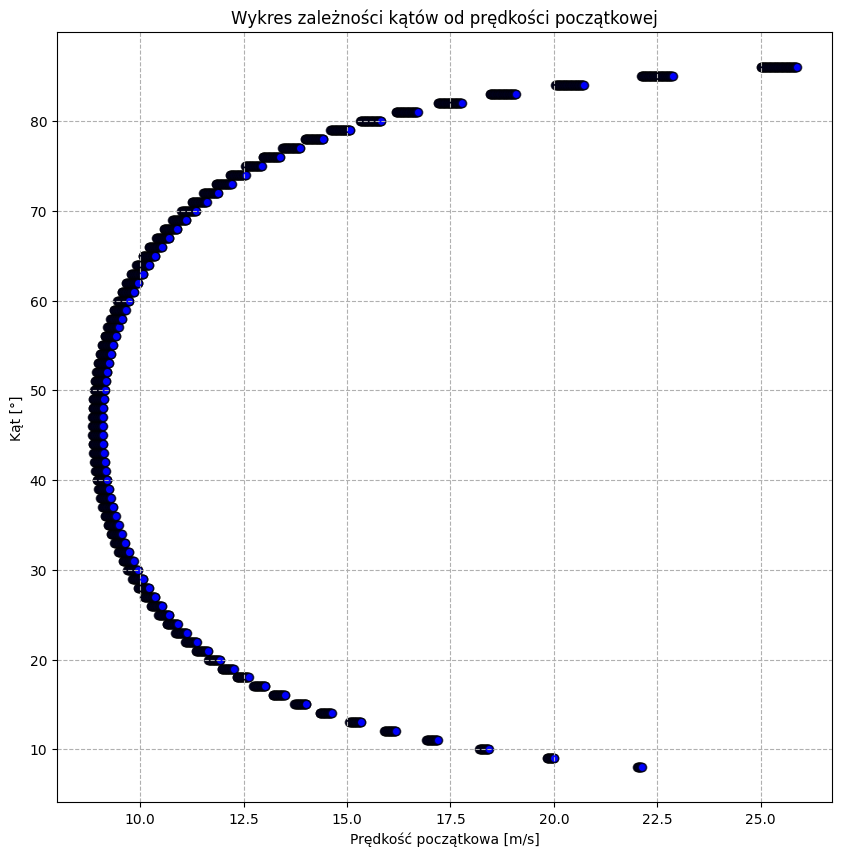

In [14]:
df = show_speeds_angles_chart(scoring_combinations)

In [15]:
grouped = df.groupby('Prędkość początkowa')['Kąty'].apply(list).reset_index()
grouped

Prędkość początkowa                                        Kąty
0                    8.84                          [45.0, 46.0, 47.0]
1                    8.85              [44.0, 45.0, 46.0, 47.0, 48.0]
2                    8.86        [44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
3                    8.87  [43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
4                    8.88  [43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
...                   ...                                         ...
1213                25.83                                      [86.0]
1214                25.84                                      [86.0]
1215                25.85                                      [86.0]
1216                25.86                                      [86.0]
1217                25.87                                      [86.0]

[1218 rows x 2 columns]

Wartość minimalnej prędkości, dla której możliwe jest znalezienie kąta umożliwiającego trafienie.

In [16]:
grouped.sort_values(by='Prędkość początkowa', ascending=True, inplace=True)
min_speed = grouped.iloc[0]
min_speed

Prędkość początkowa                  8.84
Kąty                   [45.0, 46.0, 47.0]
Name: 0, dtype: object

In [17]:
v0 = scoring_combinations[0][0]  # prędkość początkowa piłki [m/s]
alpha = scoring_combinations[0][1]  # kąt w chwili rzutu [°]
trajectory = calculate_trajectory(v0, np.radians(alpha), air_resistance_model, number_of_points)

Animacja wykonana dla najmniejszej znalezionej prędkości i 1. znalezionego kąta

Piłka wpadła do kosza!
x=7.017837344518251, y=3.1699849554580464


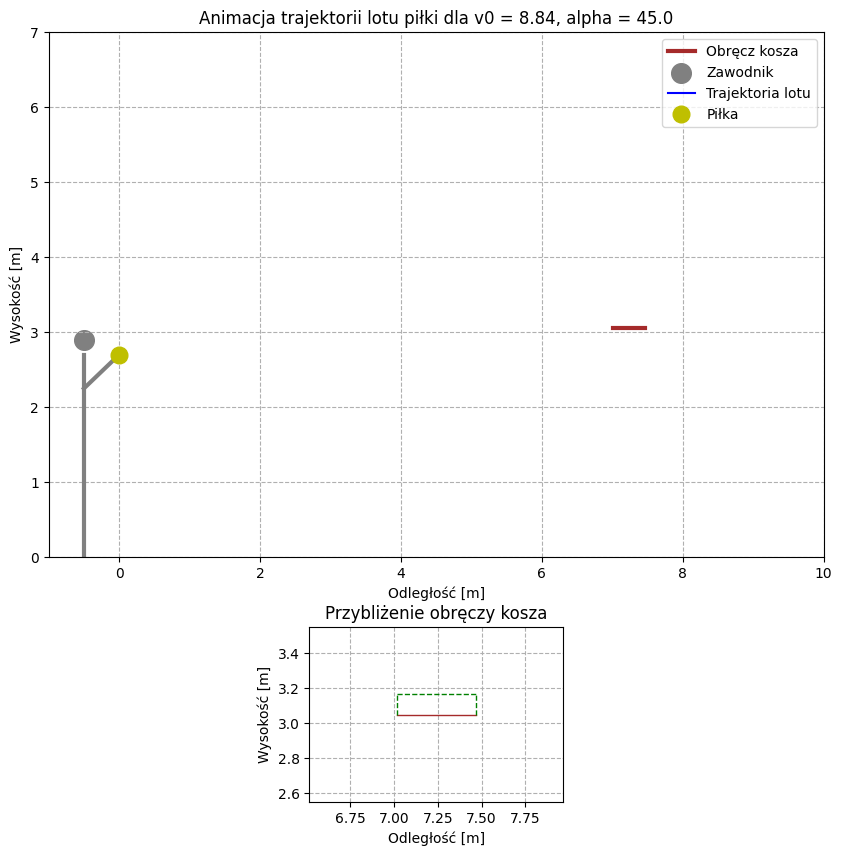

In [18]:
animation = animate_trajectory(trajectory, v0, alpha, points_reduction_divider)
HTML(animation.to_jshtml())

# Model oporu powietrza kwadratowy

In [19]:
air_resistance_model = 'kwadratowy'  # liniowy / kwadratowy
number_of_points = 10000
points_reduction_divider = 500
v_max = 100.
number_of_v = 10000

In [20]:
scoring_combinations = find_scoring_combinations(air_resistance_model, number_of_points, v_max, number_of_v)
print('Trafiające kombinacje:')
for v, a in scoring_combinations:
    print(f'Prędkość początkowa: {v:.2f} m/s, Kąt: {a}°')

Trafiające kombinacje:
Prędkość początkowa: 10.33 m/s, Kąt: 44.0°
Prędkość początkowa: 10.34 m/s, Kąt: 43.0°
Prędkość początkowa: 10.34 m/s, Kąt: 44.0°
Prędkość początkowa: 10.34 m/s, Kąt: 45.0°
Prędkość początkowa: 10.35 m/s, Kąt: 42.0°
Prędkość początkowa: 10.35 m/s, Kąt: 43.0°
Prędkość początkowa: 10.35 m/s, Kąt: 44.0°
Prędkość początkowa: 10.35 m/s, Kąt: 45.0°
Prędkość początkowa: 10.35 m/s, Kąt: 46.0°
Prędkość początkowa: 10.36 m/s, Kąt: 41.0°
Prędkość początkowa: 10.36 m/s, Kąt: 42.0°
Prędkość początkowa: 10.36 m/s, Kąt: 43.0°
Prędkość początkowa: 10.36 m/s, Kąt: 44.0°
Prędkość początkowa: 10.36 m/s, Kąt: 45.0°
Prędkość początkowa: 10.36 m/s, Kąt: 46.0°
Prędkość początkowa: 10.37 m/s, Kąt: 41.0°
Prędkość początkowa: 10.37 m/s, Kąt: 42.0°
Prędkość początkowa: 10.37 m/s, Kąt: 43.0°
Prędkość początkowa: 10.37 m/s, Kąt: 44.0°
Prędkość początkowa: 10.37 m/s, Kąt: 45.0°
Prędkość początkowa: 10.37 m/s, Kąt: 46.0°
Prędkość początkowa: 10.37 m/s, Kąt: 47.0°
Prędkość początkowa: 10.38 m/s,

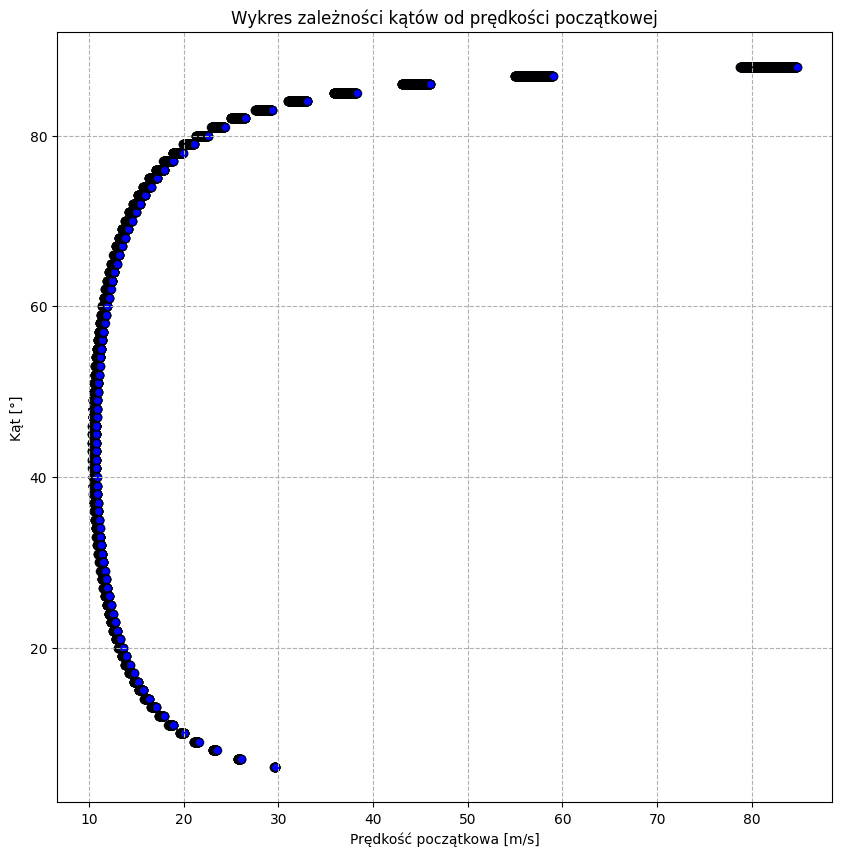

In [21]:
df = show_speeds_angles_chart(scoring_combinations)

In [22]:
grouped = df.groupby('Prędkość początkowa')['Kąty'].apply(list).reset_index()
grouped

Prędkość początkowa                                        Kąty
0                   10.33                                      [44.0]
1                   10.34                          [43.0, 44.0, 45.0]
2                   10.35              [42.0, 43.0, 44.0, 45.0, 46.0]
3                   10.36        [41.0, 42.0, 43.0, 44.0, 45.0, 46.0]
4                   10.37  [41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0]
...                   ...                                         ...
3440                84.69                                      [88.0]
3441                84.70                                      [88.0]
3442                84.71                                      [88.0]
3443                84.72                                      [88.0]
3444                84.73                                      [88.0]

[3445 rows x 2 columns]

Wartość minimalnej prędkości, dla której możliwe jest znalezienie kąta umożliwiającego trafienie.

In [23]:
grouped.sort_values(by='Prędkość początkowa', ascending=True, inplace=True)
min_speed = grouped.iloc[0]
min_speed

Prędkość początkowa     10.33
Kąty                   [44.0]
Name: 0, dtype: object

In [24]:
v0 = scoring_combinations[0][0]  # prędkość początkowa piłki [m/s]
alpha = scoring_combinations[0][1]  # kąt w chwili rzutu [°]
trajectory = calculate_trajectory(v0, np.radians(alpha), air_resistance_model, number_of_points)

Animacja wykonana dla najmniejszej znalezionej prędkości i 1. znalezionego kąta

Piłka wpadła do kosza!
x=7.015432334609487, y=3.169657378627804


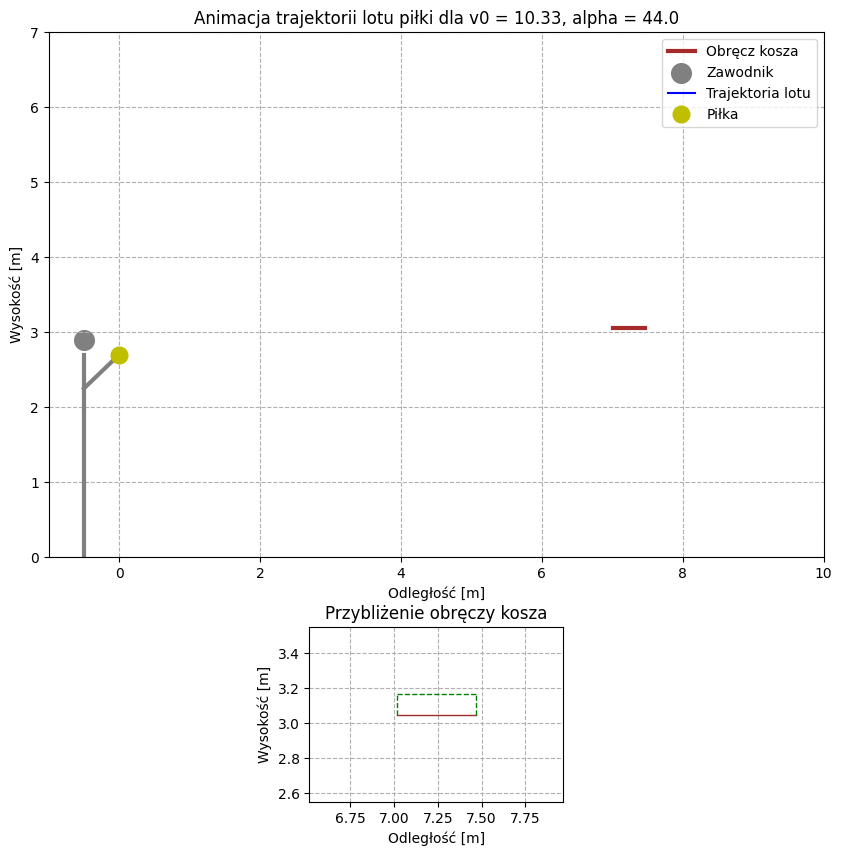

In [25]:
animation = animate_trajectory(trajectory, v0, alpha, points_reduction_divider)
HTML(animation.to_jshtml())